<a href="https://colab.research.google.com/github/m-wessler/nbm-verification/blob/main/PoWT_Synoptic_Obs_Ingest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Imports etc
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# INSTALL AND IMPORTS                                                         #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

!pip install boto3
!pip install pygrib
!pip install swifter

import gc
import os
import time
import json
import boto3
import pygrib
import swifter
import zipfile
import requests
import itertools

import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from glob import glob
from typing import List, Optional
from pydantic import BaseModel, Field

from functools import partial
from google.colab import files
from matplotlib.gridspec import GridSpec
from datetime import datetime, timedelta
from collections import defaultdict, OrderedDict

from multiprocessing import Pool, cpu_count
from multiprocessing import set_start_method, get_context

from sklearn.metrics import RocCurveDisplay
from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import (brier_score_loss, f1_score, log_loss,
                                precision_score, recall_score, roc_auc_score)

import warnings
warnings.filterwarnings('ignore')

idx = pd.IndexSlice

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.6/139.6 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.6/18.6 MB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 14.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16507 sha256=13be33435a3da3bc42b4134198284ec4cdf4ba715e5cdb494ddf53a94402d3b3
  Stored in directory: /root/.cache/pip/wheels/ef/7f/bd/9bed48f078f3ee1fa75e0b29b6e0335ce1cb03a38d3443b3a3
Successfully built swifter


In [ ]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# COLAB MARKDOWN AND USER CONFIGS                                             #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

# @markdown <FONT SIZE=5>**1. Please Provide Your Synoptic API Token...**
user_token = "a2386b75ecbc4c2784db1270695dde73" # @param {type:"string"}

# @markdown <FONT SIZE=5>**2. Select Start and End Dates**
start_date = "2025-01-01" # @param {type:"date"}
end_date = "2025-01-31" # @param {type:"date"}

## @markdown <FONT SIZE=5>**3. For Which Element?**
##"qpf24" # @param ["maxt", "mint", "qpf24", "qpf12", "qpf06"]
element = "powt"

# Split element/interval
# interval_selection = int(element[-2:]) if "qpf" in element else False
# element = element[:3] if "qpf" in element else element

#6/12/24/48/72, if element==temp then False
# interval_selection = "24" #@param ["24", "12", "6"]
# interval_selection = interval_selection if element == "qpf" else False

#temperature_threshold = -60 #@param {type:"slider", min:-60, max:140, step:10}
#qpf_threshold = 0.31 #@param {type:"slider", min:0.01, max:5.00, step:0.01}

#if element in ["maxt","mint"]:
#    threshold = temperature_threshold
#elif element in ["qpf"]:
#    threshold = qpf_threshold

# @markdown <FONT SIZE=5>**3. Which NBM Text Product?**
nbm_text_set = 'nbs' #@param ["nbh", "nbs", "nbe", "nbx"]
tolerance = 90 #@param {type:"slider", min:0, max:90, step:15}

# @markdown <FONT SIZE=5>**4. For Which Lead Time (in days)?**
lead_days_selection = 1 #@param {type:"slider", min:1, max:8, step:1}

# @markdown <FONT SIZE=5>**5. For Which Region?**
region_selection = "CWA" #@param ["WR", "SR", "CR", "ER", "CONUS", "CWA", "RFC"]

#@markdown If CWA/RFC selected, which one? (i.e. "SLC" for Salt Lake City, "CBRFC" for Colorado Basin)
cwa_selection = 'SEW,PQR,MFR,OTX,PDT' #@param {type:"string"}

## @markdown For Which Networks?
#network_selection = 'NWS+RAWS+HADS'#@param ["NWS+RAWS", "NWS+RAWS+HADS", "NWS", "RAWS", "HADS", "SNOTEL", "ALL"]
network_selection = 'NWS'

# @markdown Check box to display plots inline (default unchecked for download)
display_inline = False #@param {type:"boolean"}

In [ ]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# GLOBAL VARIABLES AND GENERAL CONFIG                                         #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

# Multiprocess settings
process_pool_size = 20 #cpu_count()*16
print(f'Process Pool Size: {process_pool_size}')

# Backend APIs
metadata_api = "https://api.synopticdata.com/v2/stations/metadata?"
qc_api = "https://api.synopticdata.com/v2/stations/qcsegments?"

# Data Query APIs
timeseries_api = "https://api.synopticdata.com/v2/stations/timeseries?"
statistics_api = "https://api.synopticlabs.org/v2/stations/statistics?"
precipitation_api = "https://api.synopticdata.com/v2/stations/precipitation?"

# Assign API to element name
synoptic_apis = {
    'qpf':precipitation_api,
    'maxt':statistics_api,
    'mint':statistics_api,
    'powt':timeseries_api}

synoptic_networks = {"NWS+RAWS+HADS":"1,2,106",
                     "NWS+RAWS":"1,2",
                     "NWS":"1",
                     "RAWS": "2",
                     "HADS": "106",
                     "SNOTEL":"25",
                     "ALL":None}
                    #  "CUSTOM": "&network="+network_input,
                    #  "LIST": "&stid="+network_input}

# Assign synoptic variable to element name
synoptic_vars = {'powt':'weather_condition,weather_summary,' \
        'weather_cond_code_synop,past_weather_code,weather_cond_code,air_temp'}

synoptic_vars_out = {
    'powt':''}

# Assign stat type to element name
stat_type = {
    'powt':None}

ob_hours = {
    'powt':['0000']}

# Where to place the grib files (subdirs can be added in local) (not used)
output_dir = './' #/nas/stid/data/nbm-verification/temp/'

# Convert user input to datetime objects
start_date, end_date = [datetime.strptime(date+' 0000', '%Y-%m-%d %H%M')
    for date in [start_date, end_date]]

# Build synoptic arg dict
synoptic_api_args = {
    'ob_stat':stat_type[element],
    'api':synoptic_apis[element],
    'element':element,
    'interval':24, #24h to poll daily powt data
    #interval_selection if element == 'qpf' else False,
    'region':region_selection,
    'network_query':synoptic_networks[network_selection], # add config feature later
    'vars_query':None if element == 'qpf'
        else f'{synoptic_vars[element]}',}

Process Pool Size: 20


In [ ]:
class PeriodOfRecord(BaseModel):
    start: str
    end: str

class Providers(BaseModel):
    name: str
    url: str

class Units(BaseModel):
    position: str
    elevation: str

class SensorVariables(BaseModel):
    air_temp: dict = Field(default_factory=dict)
    weather_summary: dict = Field(default_factory=dict)
    weather_condition: dict = Field(default_factory=dict)
    weather_cond_code: dict = Field(default_factory=dict)
    past_weather_code: dict = Field(default_factory=dict)
    weather_cond_code_synop: dict = Field(default_factory=dict)

class Observations(BaseModel):
    date_time: List[str]

    air_temp_set_1: List[Optional[float]] = Field(default_factory=list)
    air_temp_set_1d: List[Optional[float]] = Field(default_factory=list)

    weather_summary_set_1: List[Optional[str]] = Field(default_factory=list)
    weather_summary_set_1d: List[Optional[str]] = Field(default_factory=list)

    weather_condition_set_1: List[Optional[str]] = Field(default_factory=list)
    weather_condition_set_1d: List[Optional[str]] = Field(default_factory=list)

    weather_cond_code_set_1: List[Optional[float]] = Field(default_factory=list)
    weather_cond_code_set_1d: List[Optional[float]] = Field(default_factory=list)

    weather_cond_code_synop_set_1: List[Optional[object]] = Field(default_factory=list)
    weather_cond_code_synop_set_1d: List[Optional[object]] = Field(default_factory=list)

    past_weather_code_set_1: List[Optional[object]] = Field(default_factory=list)
    past_weather_code_set_1d: List[Optional[object]] = Field(default_factory=list)

    class Config:
        allow_population_by_field_name = True
        arbitrary_types_allowed = True
        strict = False

class Station(BaseModel):
    ID: str
    STID: str
    NAME: str
    ELEVATION: float
    LATITUDE: float
    LONGITUDE: float
    STATUS: str
    MNET_ID: str
    STATE: str
    TIMEZONE: str
    ELEV_DEM: object
    # NWSZONE: str
    # NWSFIREZONE: str
    # GACC: str
    SHORTNAME: str
    # SGID: str
    COUNTY: str
    # COUNTRY: str
    # WIMS_ID: str
    CWA: str
    PERIOD_OF_RECORD: PeriodOfRecord
    # PROVIDERS: Providers
    UNITS: Units
    SENSOR_VARIABLES: SensorVariables
    OBSERVATIONS: Observations
    QC_FLAGGED: bool
    RESTRICTED: bool

class Data(BaseModel):
    STATION: List[Station]

    def to_dataframe(self) -> pd.DataFrame:
        records = []

        for station in self.STATION:
            for i, date_time in enumerate(station.OBSERVATIONS.date_time):
                record = {
                    'stid': station.STID,
                    'latitude': station.LATITUDE,
                    'longitude': station.LONGITUDE,
                    'elevation': station.ELEVATION,
                    'state': station.STATE,
                    'cwa': station.CWA,
                    'timestamp':date_time,

                    'air_temp_set_1': station.OBSERVATIONS.air_temp_set_1[i] if len(station.OBSERVATIONS.air_temp_set_1) > i else None,
                    'weather_summary_set_1': station.OBSERVATIONS.weather_summary_set_1[i] if len(station.OBSERVATIONS.weather_summary_set_1) > i else None,
                    'weather_condition_set_1': station.OBSERVATIONS.weather_condition_set_1[i] if len(station.OBSERVATIONS.weather_condition_set_1) > i else None,
                    'weather_cond_code_set_1': station.OBSERVATIONS.weather_cond_code_set_1[i] if len(station.OBSERVATIONS.weather_cond_code_set_1) > i else None,
                    'past_weather_code_set_1': station.OBSERVATIONS.past_weather_code_set_1[i] if len(station.OBSERVATIONS.past_weather_code_set_1) > i else None,
                    'weather_cond_code_synop_set_1': station.OBSERVATIONS.weather_cond_code_synop_set_1[i] if len(station.OBSERVATIONS.weather_cond_code_synop_set_1) > i else None,

                    'air_temp_set_1d': station.OBSERVATIONS.air_temp_set_1d[i] if len(station.OBSERVATIONS.air_temp_set_1d) > i else None,
                    'weather_summary_set_1d': station.OBSERVATIONS.weather_summary_set_1d[i] if len(station.OBSERVATIONS.weather_summary_set_1d) > i else None,
                    'weather_condition_set_1d': station.OBSERVATIONS.weather_condition_set_1d[i] if len(station.OBSERVATIONS.weather_condition_set_1d) > i else None,
                    'weather_cond_code_set_1d': station.OBSERVATIONS.weather_cond_code_set_1d[i] if len(station.OBSERVATIONS.weather_cond_code_set_1d) > i else None,
                    'past_weather_code_set_1d': station.OBSERVATIONS.past_weather_code_set_1d[i] if len(station.OBSERVATIONS.past_weather_code_set_1d) > i else None,
                    'weather_cond_code_synop_set_1d': station.OBSERVATIONS.weather_cond_code_synop_set_1d[i] if len(station.OBSERVATIONS.weather_cond_code_synop_set_1d) > i else None
                }
                records.append(record)

        df = pd.DataFrame(records)
        return df

In [ ]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# FUNCTIONS AND METHODS (GENERAL)                                             #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

def mkdir_p(check_dir):
    from pathlib import Path
    check_dir = output_dir + check_dir
    Path(check_dir).mkdir(parents=True, exist_ok=True)
    return check_dir

In [ ]:
def cwa_list(input_region):

    input_region = input_region.upper()

    region_dict ={
        "WR":["BYZ", "BOI", "LKN", "EKA", "FGZ", "GGW", "TFX", "VEF", "LOX", "MFR",
            "MSO", "PDT", "PSR", "PIH", "PQR", "REV", "STO", "SLC", "SGX", "MTR",
            "HNX", "SEW", "OTX", "TWC"],

        "CR":["ABR", "BIS", "CYS", "LOT", "DVN", "BOU", "DMX", "DTX", "DDC", "DLH",
            "FGF", "GLD", "GJT", "GRR", "GRB", "GID", "IND", "JKL", "EAX", "ARX",
            "ILX", "LMK", "MQT", "MKX", "MPX", "LBF", "APX", "IWX", "OAX", "PAH",
            "PUB", "UNR", "RIW", "FSD", "SGF", "LSX", "TOP", "ICT"],

        "ER":["ALY", "LWX", "BGM", "BOX", "BUF", "BTV", "CAR", "CTP", "RLX", "CHS",
            "ILN", "CLE", "CAE", "GSP", "MHX", "OKX", "PHI", "PBZ", "GYX", "RAH",
            "RNK", "AKQ", "ILM"],

        "SR":["ABQ", "AMA", "FFC", "EWX", "BMX", "BRO", "CRP", "EPZ", "FWD", "HGX",
            "HUN", "JAN", "JAX", "KEY", "MRX", "LCH", "LZK", "LUB", "MLB", "MEG",
            "MAF", "MFL", "MOB", "MRX", "OHX", "LIX", "OUN", "SJT", "SHV", "TAE",
            "TBW", "TSA"]}

    if input_region == "CONUS":
        return np.hstack([region_dict[region] for region in region_dict.keys()])
    else:
        return region_dict[input_region]

def cwa_list_rfc(input_rfc):

    metadata_api = 'https://api.synopticdata.com/v2/stations/metadata?'

    network_query = (f"&network={synoptic_networks[network_selection]}"
                    if synoptic_networks[network_selection] is not None else '')

    # Assemble the API query
    api_query = (f"{metadata_api}&token={user_token}" + network_query +
                f"&complete=1&sensorvars=1,obrange=20230118") #hardcoded for NBM4.1+

    # Print the API query to output
    # print(api_query)

    # Get the data from the API
    response = requests.get(api_query)
    metadata = pd.DataFrame(response.json()['STATION'])

    # Remove NaNs and index by network, station ID
    metadata = metadata[metadata['MNET_SHORTNAME'].notna()]
    metadata = metadata.set_index(['MNET_SHORTNAME', 'STID'])

    metadata['LATITUDE'] = metadata['LATITUDE'].astype(float)
    metadata['LONGITUDE'] = metadata['LONGITUDE'].astype(float)
    metadata['ELEVATION'] = metadata['ELEVATION'].astype(float)

    metadata = metadata[metadata['LATITUDE'] >= 31]
    metadata = metadata[metadata['LONGITUDE'] <= -103.00]
    metadata = metadata[metadata['STATUS'] == 'ACTIVE']

    geometry = gpd.points_from_xy(metadata.LONGITUDE, metadata.LATITUDE)
    metadata = gpd.GeoDataFrame(metadata, geometry=geometry)

    req = requests.get(
        'https://www.weather.gov/source/gis/Shapefiles/Misc/rf05mr24.zip',

    allow_redirects=True)
    open('rf05mr24.zip', 'wb').write(req.content)

    with zipfile.ZipFile('rf05mr24.zip', 'r') as zip_ref:
        zip_ref.extractall()

    rfc_shp = gpd.read_file('rf05mr24.shp').set_index('BASIN_ID')

    metadata = metadata[metadata.geometry.within(rfc_shp.geometry.loc[input_rfc])]

    rfc_site_list = metadata.index.get_level_values(1).unique()
    rfc_cwa_list = metadata['CWA'].unique()

    return metadata

In [ ]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# FUNCTIONS AND METHODS (SYNOPTIC API)                                        #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

def fetch_obs_from_API(valid_datetime, cwa='', output_type='json',
                       use_saved=True, **req):

    start_adjusted = (datetime.strptime(valid_datetime, '%Y%m%d%H%M')
                        - timedelta(hours=req["interval"]))

    end_adjusted = datetime.strptime(valid_datetime, '%Y%m%d%H%M')

    valid = True
    cwa_filename = (region_selection if region_selection != 'CWA'
                    else cwa_selection)

    element_label = req['element'] if req['element'] != 'qpf' else \
                        'qpe' + f'{req["interval"]:02d}'


    output_file = mkdir_p(f'obs_{output_type}/') +\
        f'obs.{element_label}.{req["ob_stat"]}' +\
        f'.{valid_datetime}.{cwa_filename}.{output_type}'

    if os.path.isfile(output_file) & use_saved:
        print(f'Output file exists for:{iter_item}')

        with open(output_file, 'r') as f:
            data = Data.model_validate_json(f.read())

            # Convert to DataFrame
            df = data.to_dataframe()
            df['timestamp'] = pd.to_datetime(df['timestamp']).dt.tz_localize(None)

            return df

    else:
        json_file = mkdir_p('obs_json/') +\
            f'obs.{element_label}.{req["ob_stat"]}' +\
            f'.{valid_datetime}.{cwa_filename}.json'

        # if os.path.isfile(json_file) & use_saved:
        #     # print(f'Polling archived JSON for: {iter_item}')

        #     with open(json_file, 'rb+') as rfp:
        #         response_dataframe = pd.json_normalize(json.load(rfp)['STATION'])

        # else:
        api_query_args = {
            'api_token':f'&token={user_token}',
            'station_query':f'&cwa={cwa}',
            'network_query':(f'&network={req["network_query"]}'
                                if req["network_query"] is not None else ''),

            'start_date_query':f'&start={start_adjusted.strftime("%Y%m%d%H%M")}',
            'end_date_query':f'&end={end_adjusted.strftime("%Y%m%d%H%M")}',

            'vars_query':(f'&pmode=intervals&interval={req["interval"]}'
                            if req["element"] == 'qpf'
                            else f'&vars={req["vars_query"]}'),
            'stats_query':f'&type={req["ob_stat"]}',
            'timezone_query':'&obtimezone=utc',
            'api_extras':'&units=temp|f&complete=True'}
                #'&fields=name,status,latitude,longitude,elevation'

        api_query = req['api'] + ''.join(
            [api_query_args[k] for k in api_query_args.keys()])

        print(f'Polling API for: {iter_item}\n{api_query}')

        status_code, response_count = None, 0
        while (status_code != 200) & (response_count <= 10):
            print(f'{iter_item}, HTTP:{status_code}, #:{response_count}')

            # Don't sleep first try, sleep increasing amount for each retry
            time.sleep(2*response_count)

            response = requests.get(api_query)
            # response.raise_for_status()

            status_code = response.status_code
            response_count += 1

        try:
            response_dataframe = pd.json_normalize(
                response.json()['STATION'])
        except:
            valid = False
        else:
            with open(json_file, 'wb+') as wfp:
                wfp.write(response.content)

    if valid:
        # Example usage
        # with open('sample.json', 'r') as f:
        data = Data.model_validate_json(response.content)

        # Convert to DataFrame
        df = data.to_dataframe()
        df['timestamp'] = pd.to_datetime(df['timestamp']).dt.tz_localize(None)

        return df

    else:
        return None

In [ ]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# INPUT-BASED GLOBAL VARIABLES AND CONFIG                                     #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

# Build an iterable date list from range
iter_date = start_date
valid_date_iterable = []
valid_datetime_iterable = []
forecast_datetime_iterable = []

while iter_date <= end_date:

    valid_date_iterable.append(iter_date.strftime('%Y%m%d'))

    for hour_range in ob_hours[element]:
        end_hour = f'{int(hour_range[-1]):02d}'

        valid_datetime_iterable.append(iter_date.strftime('%Y%m%d') + end_hour)

        forecast_datetime_iterable.append(
                (iter_date-timedelta(days=lead_days_selection)
            ).strftime('%Y%m%d') + end_hour)

    iter_date += timedelta(days=1)

# Assign the fixed kwargs to the function
if region_selection == 'CWA':
    cwa_query = cwa_selection
elif region_selection == 'RFC':
    rfc_metadata = cwa_list_rfc(cwa_selection)
    cwa_query = ','.join([str(cwa) for cwa in rfc_metadata['CWA'].unique()
                if cwa is not None])
else:
    cwa_query = ','.join(cwa_list(region_selection))

In [ ]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# DATA ACQUISITION                                                            #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
multiprocess_function = partial(fetch_obs_from_API,
                                cwa=cwa_query,
                                **synoptic_api_args)

df_list = []
# Multithreaded requests currently not supported by the Synoptic API
for iter_item in valid_datetime_iterable:
    df_list.append(multiprocess_function(iter_item))

df = pd.concat(df_list).set_index(['timestamp', 'stid']).sort_index().drop_duplicates()

# Combine similarly named columns
for col in df.columns:
    if col.endswith('_1'):
        new_col_name = col[:-6]  # Remove the last two characters (_1)
        df[new_col_name] = df[col].combine_first(df[col + 'd'])  # Keep non-NaN values

# Drop the original _1 and _1d columns if needed
obs = df.drop(columns=[col for col in df.columns if col.endswith(('_1', '_1d'))])

# Display the resulting DataFrame
obs

Polling API for: 2025010100
https://api.synopticdata.com/v2/stations/timeseries?&token=a2386b75ecbc4c2784db1270695dde73&cwa=SEW,PQR,MFR,OTX,PDT&network=1&start=202412310000&end=202501010000&vars=weather_condition,weather_summary,weather_cond_code_synop,past_weather_code,weather_cond_code,air_temp&type=None&obtimezone=utc&units=temp|f&complete=True
2025010100, HTTP:None, #:0
Polling API for: 2025010200
https://api.synopticdata.com/v2/stations/timeseries?&token=a2386b75ecbc4c2784db1270695dde73&cwa=SEW,PQR,MFR,OTX,PDT&network=1&start=202501010000&end=202501020000&vars=weather_condition,weather_summary,weather_cond_code_synop,past_weather_code,weather_cond_code,air_temp&type=None&obtimezone=utc&units=temp|f&complete=True
2025010200, HTTP:None, #:0
Polling API for: 2025010300
https://api.synopticdata.com/v2/stations/timeseries?&token=a2386b75ecbc4c2784db1270695dde73&cwa=SEW,PQR,MFR,OTX,PDT&network=1&start=202501020000&end=202501030000&vars=weather_condition,weather_summary,weather_cond_code

latitude  longitude  elevation state  cwa air_temp  \
timestamp           stid                                                       
2024-12-31 00:00:00 KAAT  41.48362 -120.56150     4383.0    CA  MFR     35.6   
                    KALW  46.09462 -118.28580     1168.0    WA  PDT     42.8   
                    KAST  46.15694 -123.88250       10.0    OR  PQR     48.2   
                    KAWO  48.15850 -122.15909      125.0    WA  SEW     42.8   
                    KBFI  47.54548 -122.31470       20.0    WA  SEW     46.4   
...                            ...        ...        ...   ...  ...      ...   
2025-01-30 23:53:00 KGEG  47.62139 -117.52778     2372.0    WA  OTX    37.04   
2025-01-30 23:55:00 KSKA  47.61667 -117.65000     2461.0    WA  OTX    40.28   
                    KTCM  47.15000 -122.48333      322.0    WA  SEW    44.96   
2025-01-30 23:56:00 KCOE  47.76667 -116.81667     2320.0    ID  OTX    39.92   
2025-01-31 00:00:00 KLMT  42.14703 -121.72548     4081.0    OR  MFR     53.6   

                         weather_summary weather_condition weather_cond_code  \
timestamp           stid                                                       
2024-12-31 00:00:00 KAAT           clear              None              None   
                    KALW           clear              None              None   
                    KAST        overcast              None              None   
                    KAWO      light rain        light rain              13.0   
                    KBFI        overcast              None              None   
...                                  ...               ...               ...   
2025-01-30 23:53:00 KGEG          broken              None              None   
2025-01-30 23:55:00 KSKA          broken              None              None   
                    KTCM          broken              None              None   
2025-01-30 23:56:00 KCOE           clear              None              None   
2025-01-31 00:00:00 KLMT           clear              None              None   

                         past_weather_code weather_cond_code_synop  
timestamp           stid                                            
2024-12-31 00:00:00 KAAT              None                    None  
                    KALW              None                    None  
                    KAST              None                    None  
                    KAWO              None                    None  
                    KBFI              None                    None  
...                                    ...                     ...  
2025-01-30 23:53:00 KGEG              None                    None  
2025-01-30 23:55:00 KSKA              None                    None  
                    KTCM              None                    None  
2025-01-30 23:56:00 KCOE              None                    None  
2025-01-31 00:00:00 KLMT              None                    None  

[22256 rows x 11 columns]

In [ ]:
# obs.to_csv('obs.csv')
# del obs
# obs = pd.read_csv('obs.csv').replace(np.nan, None)
obs['weather_condition'] = obs['weather_condition'].astype(str)
obs

latitude  longitude  elevation state  cwa air_temp  \
timestamp           stid                                                       
2024-12-31 00:00:00 KAAT  41.48362 -120.56150     4383.0    CA  MFR     35.6   
                    KALW  46.09462 -118.28580     1168.0    WA  PDT     42.8   
                    KAST  46.15694 -123.88250       10.0    OR  PQR     48.2   
                    KAWO  48.15850 -122.15909      125.0    WA  SEW     42.8   
                    KBFI  47.54548 -122.31470       20.0    WA  SEW     46.4   
...                            ...        ...        ...   ...  ...      ...   
2025-01-30 23:53:00 KGEG  47.62139 -117.52778     2372.0    WA  OTX    37.04   
2025-01-30 23:55:00 KSKA  47.61667 -117.65000     2461.0    WA  OTX    40.28   
                    KTCM  47.15000 -122.48333      322.0    WA  SEW    44.96   
2025-01-30 23:56:00 KCOE  47.76667 -116.81667     2320.0    ID  OTX    39.92   
2025-01-31 00:00:00 KLMT  42.14703 -121.72548     4081.0    OR  MFR     53.6   

                         weather_summary weather_condition weather_cond_code  \
timestamp           stid                                                       
2024-12-31 00:00:00 KAAT           clear              None              None   
                    KALW           clear              None              None   
                    KAST        overcast              None              None   
                    KAWO      light rain        light rain              13.0   
                    KBFI        overcast              None              None   
...                                  ...               ...               ...   
2025-01-30 23:53:00 KGEG          broken              None              None   
2025-01-30 23:55:00 KSKA          broken              None              None   
                    KTCM          broken              None              None   
2025-01-30 23:56:00 KCOE           clear              None              None   
2025-01-31 00:00:00 KLMT           clear              None              None   

                         past_weather_code weather_cond_code_synop  
timestamp           stid                                            
2024-12-31 00:00:00 KAAT              None                    None  
                    KALW              None                    None  
                    KAST              None                    None  
                    KAWO              None                    None  
                    KBFI              None                    None  
...                                    ...                     ...  
2025-01-30 23:53:00 KGEG              None                    None  
2025-01-30 23:55:00 KSKA              None                    None  
                    KTCM              None                    None  
2025-01-30 23:56:00 KCOE              None                    None  
2025-01-31 00:00:00 KLMT              None                    None  

[22256 rows x 11 columns]

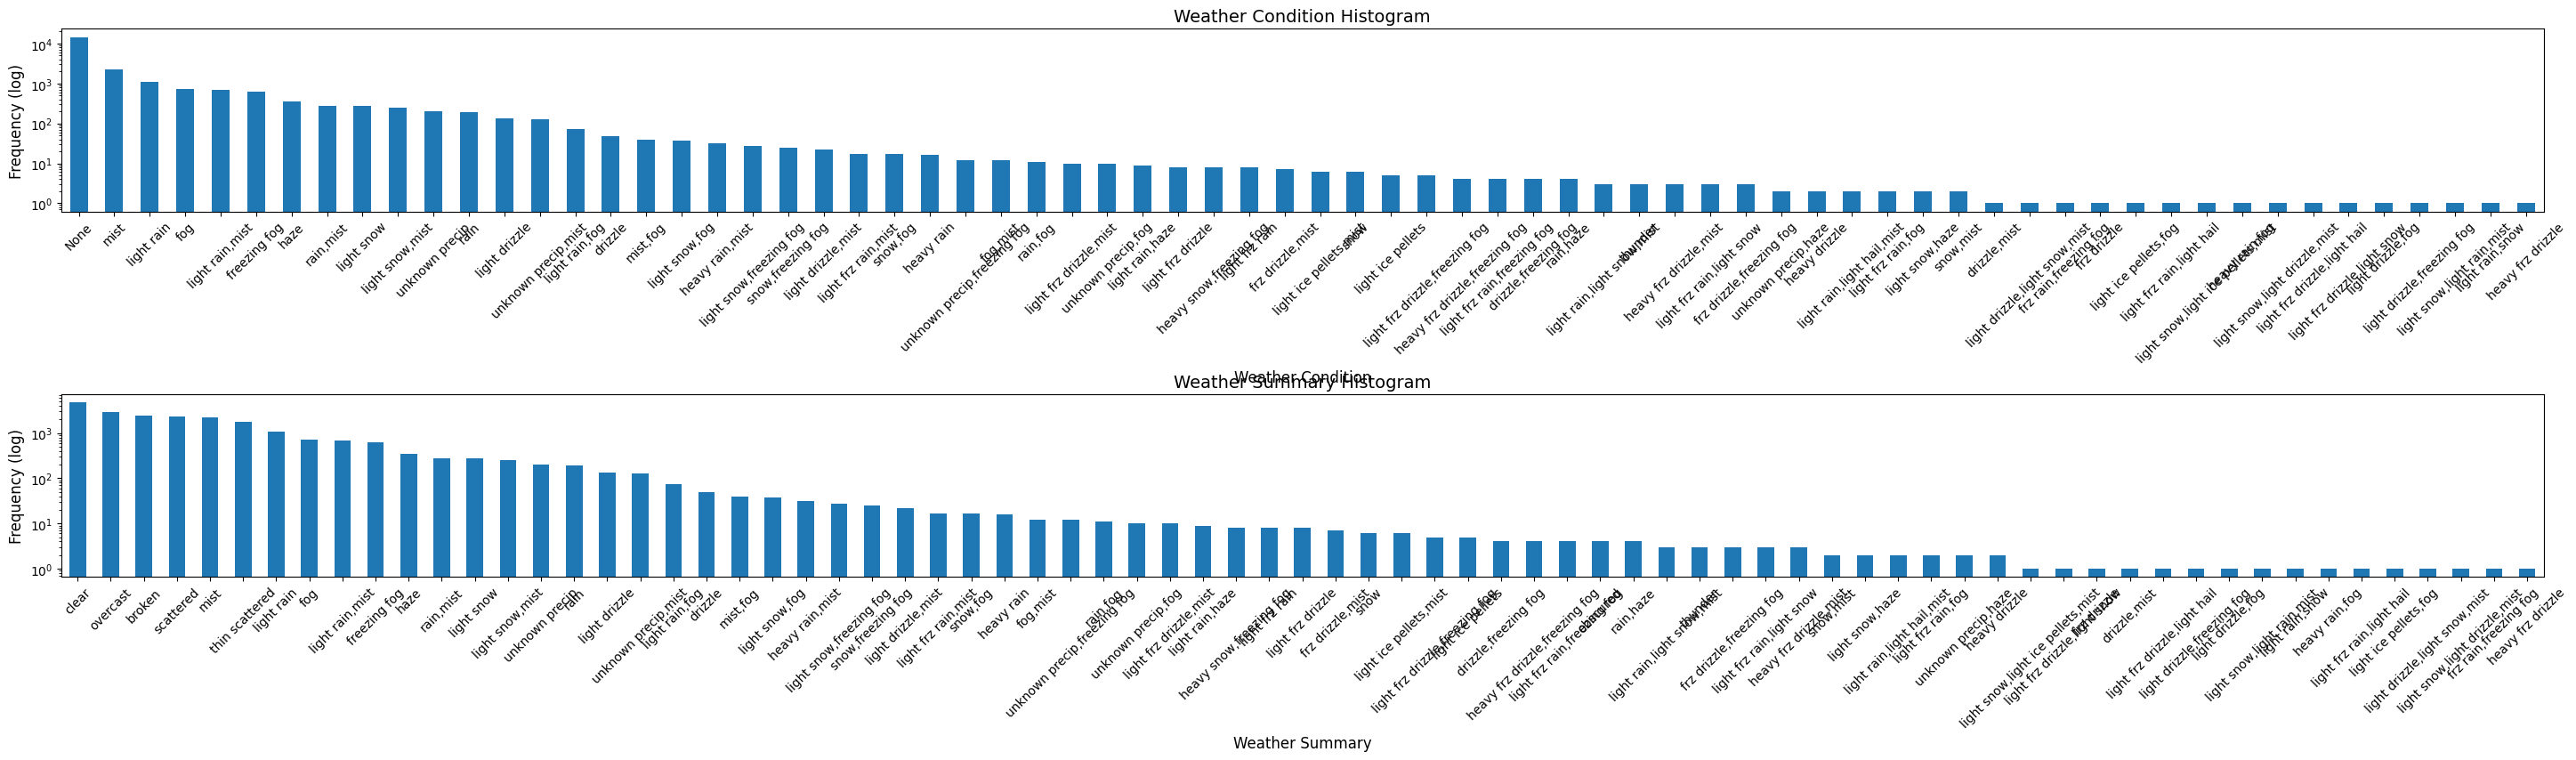

In [ ]:
# prompt: plot a vertically stacked two panel plot of histograms for columns weather_condition and weather_summary from the obs pandas dataframe with a log y axis and x ticks rotated 45 degrees and size 10 font

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(36, 8))
gs = GridSpec(2, 1, figure=fig, hspace=1)

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])

obs['weather_condition'].value_counts().plot(kind='bar', ax=ax0,logy=True)
ax0.set_title('Weather Condition Histogram', fontsize=14)
ax0.set_xlabel('Weather Condition', fontsize=12)
ax0.set_ylabel('Frequency (log)', fontsize=12)
ax0.tick_params(axis='x', rotation=45, labelsize=10)

obs['weather_summary'].value_counts().plot(kind='bar', ax=ax1,logy=True)
ax1.set_title('Weather Summary Histogram', fontsize=14)
ax1.set_xlabel('Weather Summary', fontsize=12)
ax1.set_ylabel('Frequency (log)', fontsize=12)
ax1.tick_params(axis='x', rotation=45, labelsize=10)

plt.show()

In [ ]:
obs['weather_condition'].values

array(['None', 'None', 'None', ..., 'None', 'None', 'None'], dtype=object)

In [ ]:
raw_wx_conds = [v.split(',') for v in obs['weather_condition'].values if v is not None]
wx_conds = np.hstack([v.split('/') for v in np.unique(np.hstack(raw_wx_conds))])
wx_conds

array(['None', 'drizzle', 'fog', 'freezing fog', 'frz drizzle',
       'frz rain', 'haze', 'heavy drizzle', 'heavy frz drizzle',
       'heavy rain', 'heavy snow', 'light drizzle', 'light frz drizzle',
       'light frz rain', 'light hail', 'light ice pellets', 'light rain',
       'light snow', 'mist', 'rain', 'snow', 'thunder', 'unknown precip'],
      dtype='<U17')

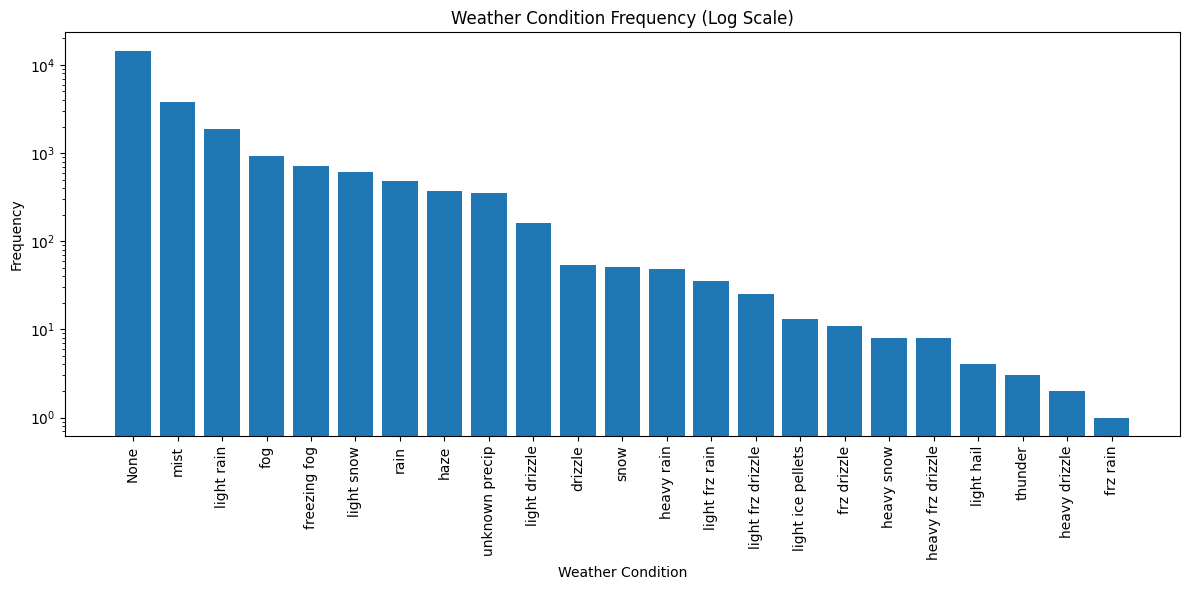

In [ ]:
# prompt: plot a histogram of the number of times each item in wx_conds appears in obs['weather_condition'] sorted from most to least with a log y axis

import matplotlib.pyplot as plt

# Assuming 'obs' and 'wx_conds' are already defined as in the provided code

wx_counts = obs['weather_condition'].str.split(',|/').explode().value_counts()
wx_counts = wx_counts.sort_values(ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(wx_counts.index, wx_counts.values)
plt.yscale('log')
plt.xticks(rotation=90)
plt.title('Weather Condition Frequency (Log Scale)')
plt.xlabel('Weather Condition')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [ ]:
obs

latitude  longitude  elevation state  cwa air_temp  \
timestamp           stid                                                       
2024-12-31 00:00:00 KAAT  41.48362 -120.56150     4383.0    CA  MFR     35.6   
                    KALW  46.09462 -118.28580     1168.0    WA  PDT     42.8   
                    KAST  46.15694 -123.88250       10.0    OR  PQR     48.2   
                    KAWO  48.15850 -122.15909      125.0    WA  SEW     42.8   
                    KBFI  47.54548 -122.31470       20.0    WA  SEW     46.4   
...                            ...        ...        ...   ...  ...      ...   
2025-01-30 23:53:00 KGEG  47.62139 -117.52778     2372.0    WA  OTX    37.04   
2025-01-30 23:55:00 KSKA  47.61667 -117.65000     2461.0    WA  OTX    40.28   
                    KTCM  47.15000 -122.48333      322.0    WA  SEW    44.96   
2025-01-30 23:56:00 KCOE  47.76667 -116.81667     2320.0    ID  OTX    39.92   
2025-01-31 00:00:00 KLMT  42.14703 -121.72548     4081.0    OR  MFR     53.6   

                         weather_summary weather_condition weather_cond_code  \
timestamp           stid                                                       
2024-12-31 00:00:00 KAAT           clear              None              None   
                    KALW           clear              None              None   
                    KAST        overcast              None              None   
                    KAWO      light rain        light rain              13.0   
                    KBFI        overcast              None              None   
...                                  ...               ...               ...   
2025-01-30 23:53:00 KGEG          broken              None              None   
2025-01-30 23:55:00 KSKA          broken              None              None   
                    KTCM          broken              None              None   
2025-01-30 23:56:00 KCOE           clear              None              None   
2025-01-31 00:00:00 KLMT           clear              None              None   

                         past_weather_code weather_cond_code_synop  
timestamp           stid                                            
2024-12-31 00:00:00 KAAT              None                    None  
                    KALW              None                    None  
                    KAST              None                    None  
                    KAWO              None                    None  
                    KBFI              None                    None  
...                                    ...                     ...  
2025-01-30 23:53:00 KGEG              None                    None  
2025-01-30 23:55:00 KSKA              None                    None  
                    KTCM              None                    None  
2025-01-30 23:56:00 KCOE              None                    None  
2025-01-31 00:00:00 KLMT              None                    None  

[22256 rows x 11 columns]

In [ ]:
# PRA: Contains "rain" or "drizzle" but not "frz"
obs['PRA'] = obs['weather_condition'].str.contains(r'\brain\b|\bdrizzle\b', case=False, na=False) & \
             ~obs['weather_condition'].str.contains(r'\bfrz\b', case=False, na=False)

# PSN: Contains "snow", "grains", or "graupel"
obs['PSN'] = obs['weather_condition'].str.contains(r'\bsnow\b|\bgrains\b|\bgraupel\b', case=False, na=False)

# PZR: Contains "frz" but not "fog"
obs['PZR'] = obs['weather_condition'].str.contains(r'\bfrz\b', case=False, na=False) & \
             ~obs['weather_condition'].str.contains(r'\bfog\b', case=False, na=False)

# PPL: Contains "ice" or "pellets" but not "fog"
obs['PPL'] = obs['weather_condition'].str.contains(r'\bice\b|\bpellets\b', case=False, na=False) & \
             ~obs['weather_condition'].str.contains(r'\bfog\b', case=False, na=False)

print(obs)

                          latitude  longitude  elevation state  cwa air_temp  \
timestamp           stid                                                       
2024-12-31 00:00:00 KAAT  41.48362 -120.56150     4383.0    CA  MFR     35.6   
                    KALW  46.09462 -118.28580     1168.0    WA  PDT     42.8   
                    KAST  46.15694 -123.88250       10.0    OR  PQR     48.2   
                    KAWO  48.15850 -122.15909      125.0    WA  SEW     42.8   
                    KBFI  47.54548 -122.31470       20.0    WA  SEW     46.4   
...                            ...        ...        ...   ...  ...      ...   
2025-01-30 23:53:00 KGEG  47.62139 -117.52778     2372.0    WA  OTX    37.04   
2025-01-30 23:55:00 KSKA  47.61667 -117.65000     2461.0    WA  OTX    40.28   
                    KTCM  47.15000 -122.48333      322.0    WA  SEW    44.96   
2025-01-30 23:56:00 KCOE  47.76667 -116.81667     2320.0    ID  OTX    39.92   
2025-01-31 00:00:00 KLMT  42.14703 -121.

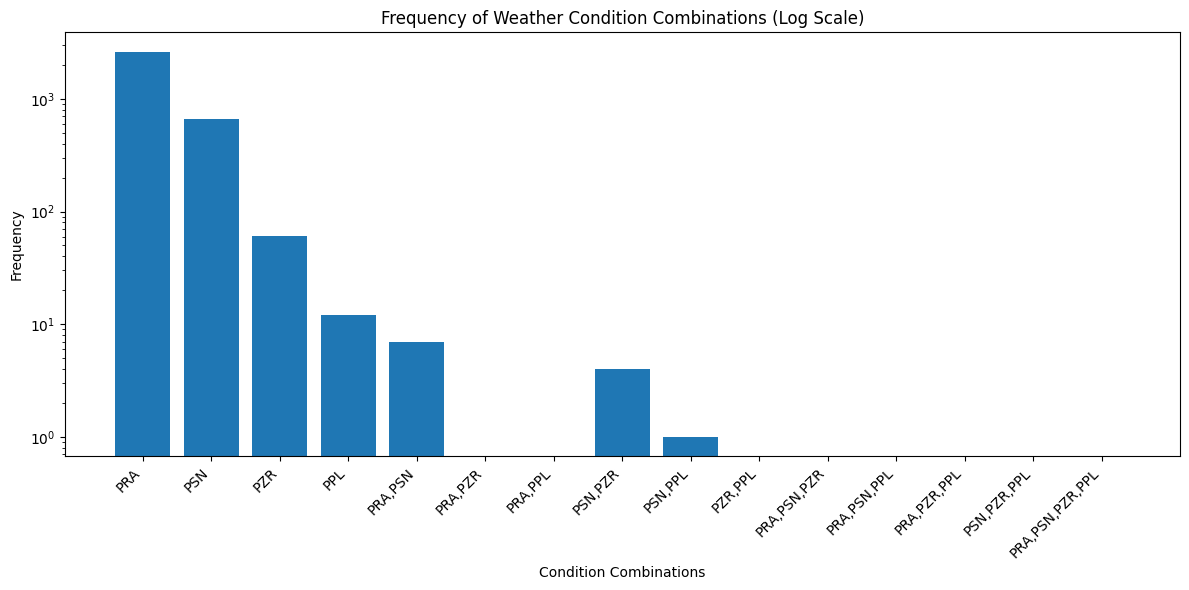

In [ ]:
# prompt: plot a histogram of the frequency with which each column PRA, PSN, PZR, and PPL are true, with additional bars for cases where multiple conditions are true, labeled by the combinations

import matplotlib.pyplot as plt

# Assuming 'obs' DataFrame is already created with 'PRA', 'PSN', 'PZR', 'PPL' columns

# Create a dictionary to store combination counts
combination_counts = {}

# Iterate through all possible combinations of conditions
for i in range(1, 5):  # Iterate through combinations of 1 to 4 conditions
    for combo in itertools.combinations(['PRA', 'PSN', 'PZR', 'PPL'], i):
        # Create a boolean series indicating if the combination is present
        combo_series = obs[list(combo)].all(axis=1)

        # Count the occurrences of the combination
        combination_counts[','.join(combo)] = combo_series.sum()

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(combination_counts.keys(), combination_counts.values())
plt.xticks(rotation=45, ha='right')
plt.yscale('log')
plt.title('Frequency of Weather Condition Combinations (Log Scale)')
plt.xlabel('Condition Combinations')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()